In [1]:
import pathlib
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from sklearn import covariance
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
import networkx as nx
from exchange.ftx.client import FtxClient

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

client = FtxClient()


#### Functions

In [225]:
def calculate_hurst(df):
    ts = df.values

    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0] * 2.0


def calculat_half_life(df):
    df_lag = df.shift(1)
    df_delta = df - df_lag
    lin_reg_model = LinearRegression()
    df_delta = df_delta.values.reshape(len(df_delta),1)                    # sklearn needs (row, 1) instead of (row,)
    df_lag = df_lag.values.reshape(len(df_lag),1)
    lin_reg_model.fit(df_lag[1:], df_delta[1:])                           # skip first line nan
    half_life = -np.log(2) / lin_reg_model.coef_.item()
    return half_life


def calculate_johansen(y, p, crit_val=1):
        """
        Get the cointegration vectors at 95% level of significance
        given by the trace statistic test.
        """

        N, l = y.shape
        jres = coint_johansen(y, 0, p)
        trstat = jres.lr1                       # trace statistic
        tsignf = jres.cvt                       # critical values

        r = 0
        for i in range(l):
            if trstat[i] > tsignf[i, crit_val]:     # 0: 90%  1:95% 2: 99%
                r = i + 1
        jres.r = r
        jres.evecr = jres.evec[:, :r]

        return jres


def get_trades(df, entry, mean, stop):
    trades = []
    positions = [0]
    long_entry = mean - entry
    short_entry = mean + entry
    long_stop = mean - stop
    short_stop = mean + stop
    current_pos = 0
    for i in range(1, len(df)):
        if i == len(df) - 1 and current_pos == 0:
            pass
        elif i == len(df) - 1 and current_pos == -1:
            trades.append({'date': df.index[i], 'trade': 'close short', 'position': 0, 'spread': df.iloc[i]})
        elif i == len(df) - 1 and current_pos == 1:
            trades.append({'date': df.index[i], 'trade': 'close long', 'position': 0, 'spread': df.iloc[i]})
        elif current_pos == 0 and df.iloc[i-1] < long_entry.iloc[i-1] and df.iloc[i] > long_entry.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'open long', 'position': 1, 'spread': df.iloc[i]})
            current_pos = 1
        elif current_pos == 0 and df.iloc[i-1] > short_entry.iloc[i-1] and df.iloc[i] < short_entry.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'open short', 'position': -1, 'spread': df.iloc[i]})
            current_pos = -1
        elif current_pos == 1 and df.iloc[i] >= mean.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close long', 'position': 0, 'spread': df.iloc[i]})
            current_pos = 0
        elif current_pos == -1 and df.iloc[i] <= mean.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close short', 'position': 0, 'spread': df.iloc[i]})
            current_pos = 0
        elif current_pos == -1 and df.iloc[i] >= short_stop.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close short', 'position': 0, 'spread': df.iloc[i]})
            current_pos = 0
        elif current_pos == 1 and df.iloc[i] <= long_stop.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close long', 'position': 0, 'spread': df.iloc[i]})
            current_pos = 0
        
        positions.append(current_pos)
    
    return (pd.DataFrame(trades), positions)


def filter_universe_graphical_lasso(prices_df, penalty=0.1, display=False):
    # implementation from https://towardsdatascience.com/machine-learning-in-action-in-finance-using-graphical-lasso-to-identify-trading-pairs-in-fa00d29c71a7
    returns = prices_df.pct_change()[1:]

    edge_model = covariance.GraphicalLassoCV()
    returns /= returns.std(axis=0)
    edge_model.fit(returns)
    p = edge_model.precision_

    #prepare the matrix for network illustration
    p = pd.DataFrame(p, columns=prices_df.columns, index=prices_df.columns)
    links = p.stack().reset_index()
    links.columns = ['var1', 'var2','value']
    links=links.loc[ (abs(links['value']) > penalty) &  (links['var1'] != links['var2']) ]

    #build the graph using networkx lib
    G=nx.from_pandas_edgelist(links,'var1','var2', create_using=nx.Graph())
    pos = nx.spring_layout(G, k=0.2*1/np.sqrt(len(G.nodes())), iterations=20)

    if display:
        plt.figure(3, figsize=(10, 10))
        nx.draw(G, pos=pos)
        nx.draw_networkx_labels(G, pos=pos)
        plt.show()
    
    return G


def get_best_pair_candidates(graph, formation_prices_df, nbr_of_candidates=10, min_dollars_per_unit=0, max_dollars_per_unit=99999):
    # Find most mean reverting pairs
    ridge = RidgeCV()
    unique_pairs = []
    possible_pairs = []
    clusters = nx.connected_components(graph)
    
    for cluster in clusters:
        perps = list(cluster)
        for perp_a in perps:
            for perp_b in perps:
                pair = '{}/{}'.format(perp_a, perp_b)
                if perp_a != perp_b and '{}/{}'.format(perp_b, perp_a) not in unique_pairs:
                    
                    # regress prices
                    ridge_reg = ridge.fit(formation_prices_df[perp_a].values.reshape(-1, 1), formation_prices_df[perp_b].values.reshape(-1, 1))
                    beta = ridge_reg.coef_[0][0]

                    if beta < 0:
                        # ignore negative betas, not sure how to interpret them for now
                        continue

                    # test for mean-reversion
                    spread =  formation_prices_df[perp_b] - beta * formation_prices_df[perp_a]
                    half_life = calculat_half_life(spread)
                    adf = adfuller(spread, 1)
                    hurst = calculate_hurst(spread)

                    # calculate positions ratio in dollars
                    total_size = formation_prices_df[perp_b] + ridge_reg.coef_[0][0] * formation_prices_df[perp_a]
                    size_ratio = formation_prices_df[perp_b] / total_size

                    if total_size.mean() < min_dollars_per_unit or total_size.mean() > max_dollars_per_unit:
                        # skip if dollars per unit is not within our limits
                        continue

                    possible_pairs.append({
                        'pair': pair,
                        'perp_a': perp_a,
                        'perp_b': perp_b,
                        'beta_units': ridge_reg.coef_[0][0],
                        'half_life': half_life,
                        'adf_pvalue': adf[1],
                        'hurst': hurst,
                        'long_short_position_ratio': size_ratio.mean()
                    })

                    unique_pairs.append(pair)

    possible_pairs = pd.DataFrame(possible_pairs)
    top_pairs = []
    unique_perps = []
    for idx in possible_pairs[(possible_pairs['half_life'] > 0)].sort_values(['half_life']).index:
        if len(top_pairs) < nbr_of_candidates:
            if possible_pairs.loc[idx]['perp_a'] not in unique_perps and possible_pairs.loc[idx]['perp_b'] not in unique_perps:
                top_pairs.append(possible_pairs.loc[idx])
                unique_perps.append(possible_pairs.loc[idx]['perp_a'])
                unique_perps.append(possible_pairs.loc[idx]['perp_b'])

    top_pairs_df = pd.DataFrame(top_pairs)
    #top_pairs = possible_pairs[(possible_pairs['half_life'] > 0)].sort_values(['half_life'])[:nbr_of_candidates]
    
    return top_pairs_df


# params = {start_date, end_date, formation_period_days, minimum_dollars_per_unit, maximum_dollars_per_unit, trading_period_days, taker_fee, entry_multiple, stop_multiple, half_life_multiple, nbr_max_pairs, display_cluster}
def backtest_mean_reversion_portfolio(prices_df, params, display=False):

    # Narrow down universe
    formation_start_date = params['start_date']
    formation_end_date = formation_start_date + timedelta(days=params['formation_period_days'])
    formation_prices_df = prices_df[formation_start_date:formation_end_date].T.dropna().T
    graph = filter_universe_graphical_lasso(formation_prices_df, 0.1, params['display_cluster'])

    # Rank and select top pairs based on mean reversion properies
    top_pairs = get_best_pair_candidates(graph, formation_prices_df, params['nbr_max_pairs'], params['minimum_dollars_per_unit'], params['maximum_dollars_per_unit'])

    # Backtest
    taker_fee = params['taker_fee']
    std_entry_multiple = params['entry_multiple']
    std_stop_multiple = params['stop_multiple']
    half_life_multiple = params['half_life_multiple']

    trading_start_date = formation_end_date
    trading_end_date = trading_start_date + timedelta(days=params['trading_period_days'])
    trading_prices_df = prices_df[trading_start_date:trading_end_date].T.dropna().T

    individual_pairs_data = []
    individual_trades_data = []
    portfolio_cumret = None
    for i in range(0, len(top_pairs)):

        row = top_pairs.iloc[i]

        single_pair_result = backtest_mean_reversion_single_pair(row, trading_prices_df, params, False)
        cumret = single_pair_result['cumulative_returns']
        cumdd = single_pair_result['max_drawdown_returns']

        if len(single_pair_result['individual_trades']) > 0:
            individual_trades_data.append(single_pair_result['individual_trades'])
            individual_pairs_data.append(pd.DataFrame({
                'pair': row['pair'],
                'returns': cumret.iloc[-1],
                'max_drawdown': cumdd.iloc[-1]
            }))

            if portfolio_cumret is None:
                portfolio_cumret = cumret/len(top_pairs)
            else:
                portfolio_cumret += cumret/len(top_pairs)
        else:
            individual_pairs_data.append(pd.DataFrame({
                'pair': row['pair'],
                'returns': [0],
                'max_drawdown': [0]
            }))
    if len(individual_pairs_data) > 0:
        individual_pairs_data_df = pd.concat(individual_pairs_data).reset_index(drop=True)
        individual_pairs_data_df['calmar_ratio'] = individual_pairs_data_df['returns'] / abs(individual_pairs_data_df['max_drawdown'])
        # must be more because no drawdown theorically, but prefer to be conservative
        individual_pairs_data_df['calmar_ratio'] = individual_pairs_data_df['calmar_ratio'].replace(np.inf, 1)
    else:
        individual_pairs_data_df = pd.DataFrame([])

    if len(individual_trades_data) > 0:
        individual_trades_data_df = pd.concat(individual_trades_data).reset_index(drop=True)
    else:
        individual_trades_data_df = pd.DataFrame([])

    # we assume equal dollar size for each pair (if i put 1,000$ in 10 pairs, total return over 10,000$ is the mean of individual pair returns)
    if portfolio_cumret is None:
        portfolio_cum_max_dd = 0
        portfolio_returns = 0
        portfolio_max_dd = 0
        portfolio_avg_calmar_ratio = 0
    else:
        portfolio_cum_max_dd = (portfolio_cumret - portfolio_cumret.cummax()).cummin()
        portfolio_returns = individual_pairs_data_df['returns'].mean()
        portfolio_max_dd = individual_pairs_data_df['max_drawdown'].mean()
        portfolio_avg_calmar_ratio = portfolio_returns / abs(portfolio_max_dd)

    if display:
        plt.figure(figsize=(15,7))
        plt.title('Portfolio Cumulative Returns (%) - Returns = {:.2f}%, Max Drawdown = {:.2f}%, Calmar Ratio = {:.2f}'.format(portfolio_returns*100, portfolio_max_dd*100, portfolio_avg_calmar_ratio))

        plt.plot(portfolio_cumret*100)
        plt.plot(portfolio_cumret.cummax()*100, color='green')
        plt.plot(portfolio_cum_max_dd*100, color='red')
    
    top_pairs['returns'] = individual_pairs_data_df['returns'].values
    top_pairs['max_drawdown'] = individual_pairs_data_df['max_drawdown'].values
    top_pairs['calmar'] = individual_pairs_data_df['calmar_ratio'].values
    
    return {
        'pairs': top_pairs,
        'returns': portfolio_returns,
        'max_drawdown': portfolio_max_dd,
        'individual_pairs': individual_pairs_data_df,
        'individual_trades': individual_trades_data_df
    }


# params = {start_date, end_date, formation_period_days, trading_period_days, taker_fee, entry_multiple, stop_multiple, half_life_multiple, nbr_max_pairs}
def backtest_mean_reversion_single_pair(pair_data, prices_df, params, display=True):

    taker_fee = params['taker_fee']
    std_entry_multiple = params['entry_multiple']
    std_stop_multiple = params['stop_multiple']
    half_life_multiple = params['half_life_multiple']

    trading_start_date = params['start_date'] + timedelta(days=params['formation_period_days'])
    trading_end_date = trading_start_date + timedelta(days=params['trading_period_days'])
    trading_prices_df = prices_df[trading_start_date:trading_end_date].T.dropna().T

    # trades
    trading_spread = (trading_prices_df[[pair_data['perp_a'], pair_data['perp_b']]] * [-pair_data['beta_units'], 1]).sum(axis=1)
    position_size = ((trading_prices_df[[pair_data['perp_a'], pair_data['perp_b']]] * [pair_data['beta_units'], 1]).sum(axis=1))
    rolling_mean = trading_spread.rolling(window=int(pair_data['half_life'] * half_life_multiple)).apply(np.mean)
    rolling_std = trading_spread.rolling(window=int(pair_data['half_life'] * half_life_multiple)).apply(np.std)
    rolling_entry = std_entry_multiple * rolling_std
    rolling_stop = std_stop_multiple * rolling_std
    trades, positions = get_trades(trading_spread, rolling_entry, rolling_mean, rolling_stop)

    # individual trade details
    individual_trades = []
    for i in range(0, len(trades)):
        if trades.iloc[i]['position'] != 0:
            unit_position_size = position_size.loc[trades.iloc[i]['date']]
            fee = unit_position_size * taker_fee
            pnl = (trading_spread.loc[trades.iloc[i + 1]['date']] - trading_spread.loc[trades.iloc[i]['date']]) * trades.iloc[i]['position']
            pnl_after_fee = pnl - fee
            ret = pnl_after_fee / position_size.loc[trades.iloc[i]['date']] # return is spread pnl in dollars divided by position value in dollars at open (logic: $ made over $ used for the trade)
            individual_trades.append({
                'pair': pair_data['pair'],
                'date_open': trades.iloc[i]['date'],
                'date_close': trades.iloc[i + 1]['date'],
                'position': trades.iloc[i]['position'],
                'price_a_open': trading_prices_df.loc[trades.iloc[i]['date']][pair_data['perp_a']],
                'price_b_open': trading_prices_df.loc[trades.iloc[i]['date']][pair_data['perp_b']],
                'price_a_close': trading_prices_df.loc[trades.iloc[i + 1]['date']][pair_data['perp_a']],
                'price_b_close': trading_prices_df.loc[trades.iloc[i + 1]['date']][pair_data['perp_b']],
                'spread_open': trading_spread.loc[trades.iloc[i]['date']],
                'spread_close': trading_spread.loc[trades.iloc[i+1]['date']],
                'beta': pair_data['beta_units'],
                'one_unit_dollar_size': unit_position_size,
                'pnl': pnl,
                'fee': fee,
                'pnl_after_fee': pnl_after_fee,
                'returns': ret,
                'duration': trades.iloc[i + 1]['date'] - trades.iloc[i]['date']
            })
    individual_trades_df = pd.DataFrame(individual_trades)

    if len(individual_trades) > 0:
        # period returns
        cumulative_pnl = individual_trades_df['pnl_after_fee'].cumsum().to_frame()
        max_drawdown_pnl = (cumulative_pnl - cumulative_pnl.cummax()).cummin()
        cumulative_returns = ((individual_trades_df['returns'] + 1).cumprod() - 1).to_frame()
        max_drawdown_returns = (cumulative_returns - cumulative_returns.cummax()).cummin()

        # adjust index
        cumulative_pnl['date'] = individual_trades_df['date_close']
        max_drawdown_pnl['date'] = individual_trades_df['date_close']
        cumulative_returns['date'] = individual_trades_df['date_close']
        max_drawdown_returns['date'] = individual_trades_df['date_close']

        cumulative_pnl = cumulative_pnl.set_index('date')
        max_drawdown_pnl = max_drawdown_pnl.set_index('date')
        cumulative_returns = cumulative_returns.set_index('date')
        max_drawdown_returns = max_drawdown_returns.set_index('date')

        cumulative_pnl = cumulative_pnl.reindex(trading_spread.index).ffill().replace(np.nan, 0)
        max_drawdown_pnl = max_drawdown_pnl.reindex(trading_spread.index).ffill().replace(np.nan, 0)
        cumulative_returns = cumulative_returns.reindex(trading_spread.index).ffill().replace(np.nan, 0)
        max_drawdown_returns = max_drawdown_returns.reindex(trading_spread.index).ffill().replace(np.nan, 0)

        # visualization
        if display:
            fig, axs = plt.subplots(3,1, figsize=(15,10))
            fig.tight_layout()
            axs[0].plot(trading_spread)
            axs[0].title.set_text('{} Spread, -{:.3f} unit(s) of {} for 1 unit of {}, Half-Life = {:.2f} bars'.format(pair_data['pair'], pair_data['beta_units'], pair_data['perp_a'], pair_data['perp_b'], pair_data['half_life']))
            axs[0].plot(rolling_mean, color='grey')
            axs[0].plot(rolling_mean + rolling_entry, color='red')
            axs[0].plot(rolling_mean + rolling_stop, color='black')
            axs[0].plot(rolling_mean - rolling_entry, color='green')
            axs[0].plot(rolling_mean - rolling_stop, color='black')
            axs[0].plot(trading_spread[trades[trades['trade'] == 'open short']['date']], linestyle='None', marker=7, color='r', markersize=10)
            axs[0].plot(trading_spread[trades[trades['trade'] == 'open long']['date']], linestyle='None', marker=6, color='g', markersize=10)
            axs[0].plot(trading_spread[trades[trades['trade'] == 'close short']['date']], linestyle='None', marker=6, color='b', markersize=10)
            axs[0].plot(trading_spread[trades[trades['trade'] == 'close long']['date']], linestyle='None', marker=7, color='b', markersize=10)

            axs[1].plot(cumulative_pnl)
            axs[1].title.set_text('Cumulative PNL')
            axs[1].plot(cumulative_pnl.cummax(), color='green')
            axs[1].plot(max_drawdown_pnl, color='red')

            axs[2].plot(cumulative_returns * 100)
            axs[2].title.set_text('Cumulative Returns (%)')
            axs[2].plot(cumulative_returns.cummax() * 100, color='green')
            axs[2].plot(max_drawdown_returns * 100, color='red')

    else:
        cumulative_returns = 0,
        max_drawdown_returns = 0

    return {
        'cumulative_returns': cumulative_returns,
        'max_drawdown_returns': max_drawdown_returns,
        'individual_trades': individual_trades_df
    }    


# params = {start_date, end_date, formation_period_days, trading_period_days, taker_fee, entry_multiple, stop_multiple, half_life_multiple, nbr_max_pairs, display_cluster}
def rolling_backtest_mean_reversion(prices_df, params, display=False):
    formation_start_date = params['start_date']
    formation_end_date = formation_start_date + timedelta(days=params['formation_period_days'])
    trading_end_date = formation_end_date + timedelta(days=params['trading_period_days'])

    rolling_pairs_data = []
    rolling_trades = []
    rolling_period_results = []
    period_params = params.copy()
    while trading_end_date <= params['end_date']:
        period_prices_df = prices_df[formation_start_date:trading_end_date].T.dropna().T
        period_params['start_date'] = formation_start_date
        period_params['end_date'] = trading_end_date
        period_backtest_result = backtest_mean_reversion_portfolio(period_prices_df, period_params)

        rolling_pairs_data.append(period_backtest_result['individual_pairs'])
        rolling_trades.append(period_backtest_result['individual_trades'])
        rolling_period_results.append({
            'period_start': formation_start_date,
            'period_end': trading_end_date,
            'returns': period_backtest_result['returns']
        })

        formation_start_date = formation_start_date + timedelta(days=params['trading_period_days'])
        trading_end_date = trading_end_date + timedelta(days=params['trading_period_days'])

    rolling_pairs_data_df = pd.concat(rolling_pairs_data)
    rolling_trades_df = pd.concat(rolling_trades)
    rolling_period_results_df = pd.DataFrame(rolling_period_results)

    backtest_cumulative_returns = ((rolling_period_results_df['returns'] + 1).cumprod() - 1)
    backtest_max_dd = (backtest_cumulative_returns - backtest_cumulative_returns.cummax()).cummin()

    if display:
        ret = backtest_cumulative_returns.iloc[-1]*100
        max_dd = backtest_max_dd.iloc[-1]*100
        bt_start = params['start_date']
        bt_end = params['end_date']

        plt.figure(figsize=(15,7))
        plt.suptitle('Cumulative Returns (%)')
        plt.title('Period: {:%Y-%m-%d} to {:%Y-%m-%d}\nReturns = {:.2f}%, Max Drawdown = {:.2f}%, Calmar Ratio = {:.2f}'.format(bt_start, bt_end, ret, max_dd, ret/abs(max_dd)))

        plt.plot(rolling_period_results_df['period_end'].values, backtest_cumulative_returns.values*100)
        plt.plot(rolling_period_results_df['period_end'].values, backtest_cumulative_returns.cummax().values*100, color='green')
        plt.plot(rolling_period_results_df['period_end'].values, backtest_max_dd.values*100, color='red')

        trade_stats = calculate_trade_statistics(rolling_trades_df)
        print('Long Ratio: {:.2f}%\nWin Rate: {:.2f}%\nAverage Win: {:.2f}%\nAverage Loss: {:.2f}%\nAverage Trade Duration: {}'.format(trade_stats['long_ratio']*100, trade_stats['win_rate']*100, trade_stats['avg_win']*100, trade_stats['avg_loss']*100, trade_stats['avg_duration']))
    
    return {
        'returns': backtest_cumulative_returns.iloc[-1],
        'periods_breakdown': rolling_period_results_df,
        'max_drawdown': backtest_max_dd,
        'rolling_pairs_data': rolling_pairs_data_df,
        'rolling_trades': rolling_trades_df
    }


def calculate_trade_statistics(trades):

    return {
        'long_ratio': len(trades[trades['position'] == 1]) / len(trades),
        'win_rate': len(trades[trades['returns'] > 0]) / len(trades),
        'avg_win': trades[trades['returns'] > 0]['returns'].mean(),
        'avg_loss': trades[trades['returns'] < 0]['returns'].mean(),
        'avg_duration': trades['duration'].mean(),
        'sharpe': trades['returns'].mean() / trades['returns'].std()
    }


#### Load data for backtest

In [3]:
# Data
minimum_volume = 5000000
resolution = '1h'
futures = client.get_futures()
perps = []
for future in futures:
    if 'PERP' in future['name'] and future['volumeUsd24h'] > minimum_volume:
        perps.append(future['name'])

ohlc = {}
prices = {}
for perp in perps:
    data = []
    try:
        if platform.system() == 'Windows':
            data_path = str(pathlib.Path().resolve().parent) + '\\data'
            data = pd.read_parquet(data_path + '\\{}_{}.parquet.gzip'.format(perp, resolution))
        else:
            data_path = str(pathlib.Path().resolve().parent) + '/data'
            data = pd.read_parquet(data_path + '/{}_{}.parquet.gzip'.format(perp, resolution))
    except:
        print('Cannot find {} data'.format(perp))
    
    if len(data) > 0:
        data['startTime'] = data['startTime'].apply(lambda x: datetime.fromisoformat(x))
        ohlc[perp] = data.set_index('startTime')
        prices[perp] = ohlc[perp]['close']

prices_df = pd.DataFrame(prices)

#### Backtest

,pair,perp_a,perp_b,beta_units,half_life,adf_pvalue,hurst,long_short_position_ratio,returns,max_drawdown,calmar
17,SRM-PERP/RAY-PERP,SRM-PERP,RAY-PERP,1.283846,4.676031,0.000409,0.149695,0.502247,-0.006182,-0.012822,-0.482131
64,SUSHI-PERP/ADA-PERP,SUSHI-PERP,ADA-PERP,0.153882,5.624220,0.000044,0.106165,0.576624,0.006886,-0.018722,0.367799
136,MVDA10-PERP/LTC-PERP,MVDA10-PERP,LTC-PERP,0.005965,5.695240,0.000086,0.134531,0.503290,0.001360,-0.003609,0.376755
98,FTT-PERP/LINK-PERP,FTT-PERP,LINK-PERP,0.611741,7.042211,0.000229,0.238196,0.435482,0.001081,-0.015921,0.067926
186,THETA-PERP/ENJ-PERP,THETA-PERP,ENJ-PERP,0.236061,8.477138,0.002144,0.176335,0.518859,0.009914,-0.010065,0.985005
9,RUNE-PERP/XTZ-PERP,RUNE-PERP,XTZ-PERP,1.063083,9.919774,0.006879,0.252513,0.460052,-0.002696,-0.021116,-0.127667
203,SHIT-PERP/MANA-PERP,SHIT-PERP,MANA-PERP,0.000103,9.946504,0.005789,0.254738,0.538228,0.006732,-0.007890,0.853287
1,FIDA-PERP/SOL-PERP,FIDA-PERP,SOL-PERP,26.787075,10.009978,0.006141,0.085250,0.471952,-0.012561,-0.014126,-0.889191
158,ETH-PERP/ETC-PERP,ETH-PERP,ETC-PERP,0.012991,10.211013,0.035513,0.267641,0.544165,0.011744,-0.003845,3.054005
40,AAVE-PERP/UNI-PERP,AAVE-PERP,UNI-PERP,0.057044,12.173619,0.014216,0.116448,0.594807,0.009501,-0.007480,1.270096


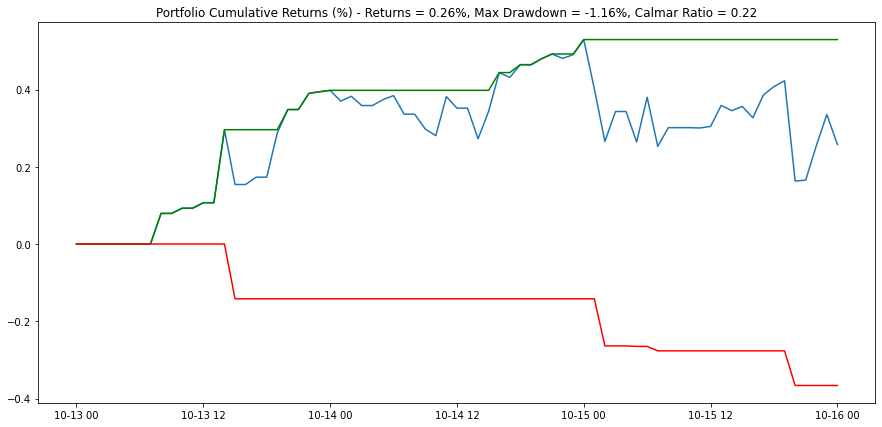

In [234]:
# Backtest
backtest_params = {
    'start_date': datetime.fromisoformat('2021-09-28 00:00:00+00:00'),
    'end_date': datetime.fromisoformat('2021-10-31 00:00:00+00:00'),
    'minimum_dollars_per_unit': 1,
    'maximum_dollars_per_unit': 1000,
    'formation_period_days': 15,
    'trading_period_days': 3,
    'taker_fee': 0.0007,
    'entry_multiple': 1,
    'stop_multiple': 2,
    'half_life_multiple': 1,
    'nbr_max_pairs': 10,
    'display_cluster': False
}

res = backtest_mean_reversion_portfolio(prices_df, backtest_params, True)
res['pairs']

<AxesSubplot:ylabel='Frequency'>

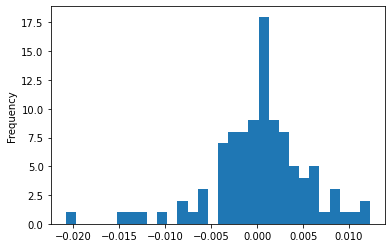

In [235]:
res['individual_trades']['returns'].plot.hist(bins=30)

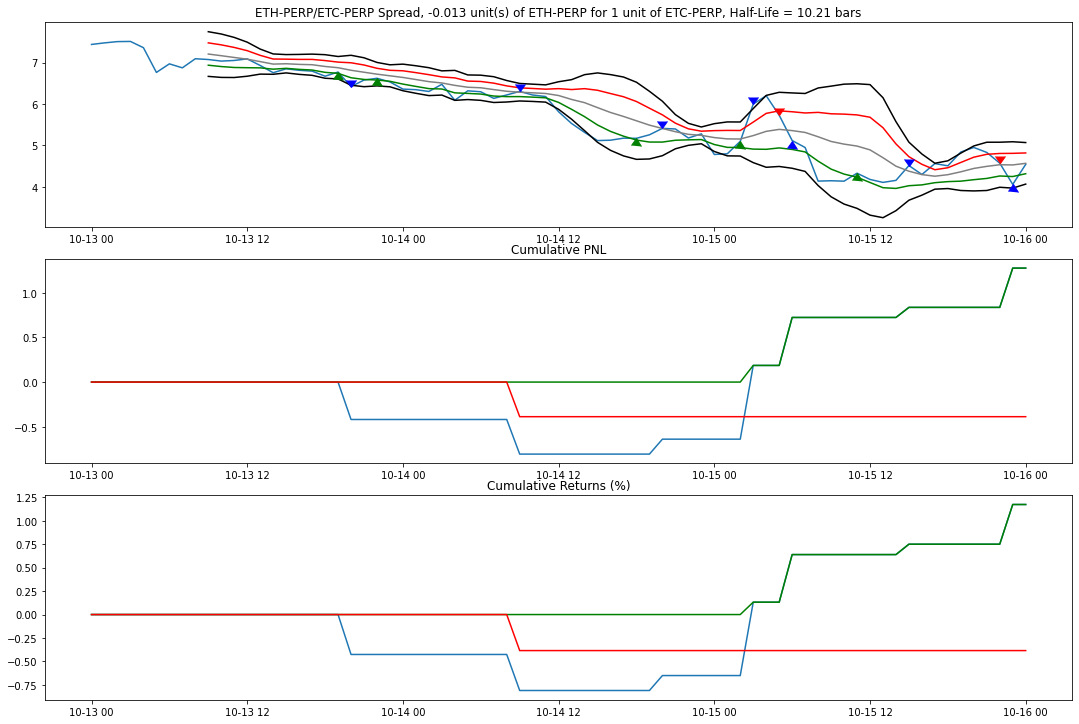

In [237]:
backtest_params_single_pair = {
    'start_date': datetime.fromisoformat('2021-09-28 00:00:00+00:00'),
    'end_date': datetime.fromisoformat('2021-10-31 00:00:00+00:00'),
    'formation_period_days': 15,
    'trading_period_days': 3,
    'taker_fee': 0.0007,
    'entry_multiple': 1,
    'stop_multiple': 2,
    'half_life_multiple': 1
}

res2 = backtest_mean_reversion_single_pair(res['pairs'].iloc[8], prices_df, backtest_params_single_pair)

In [138]:
res2['individual_trades']

,pair,date_open,date_close,position,price_a_open,price_b_open,price_a_close,price_b_close,spread_open,spread_close,beta,one_unit_dollar_size,pnl,fee,pnl_after_fee,returns,duration
0,BNB-PERP/FIL-PERP,2021-01-31 14:00:00+00:00,2021-01-31 15:00:00+00:00,-1,43.9075,22.365,43.5325,22.205,13.120001,13.038959,0.210556,31.609999,0.081041,0.022127,0.058914,0.001864,0 days 01:00:00
1,BNB-PERP/FIL-PERP,2021-01-31 18:00:00+00:00,2021-01-31 19:00:00+00:00,1,43.3475,22.125,43.9075,22.305,12.997912,13.060001,0.210556,31.252088,0.062088,0.021876,0.040212,0.001287,0 days 01:00:00
2,BNB-PERP/FIL-PERP,2021-02-01 01:00:00+00:00,2021-02-01 02:00:00+00:00,1,44.3075,22.350,44.3275,22.415,13.020778,13.081567,0.210556,31.679222,0.060789,0.022175,0.038613,0.001219,0 days 01:00:00
3,BNB-PERP/FIL-PERP,2021-02-01 04:00:00+00:00,2021-02-01 06:00:00+00:00,-1,44.8625,22.435,45.3400,22.885,12.988919,13.338379,0.210556,31.881081,-0.349459,0.022317,-0.371776,-0.011661,0 days 02:00:00
4,BNB-PERP/FIL-PERP,2021-02-01 09:00:00+00:00,2021-02-01 10:00:00+00:00,-1,47.0350,23.235,47.1500,23.045,13.331486,13.117272,0.210556,33.138514,0.214214,0.023197,0.191017,0.005764,0 days 01:00:00
5,BNB-PERP/FIL-PERP,2021-02-01 15:00:00+00:00,2021-02-02 02:00:00+00:00,1,48.2075,22.900,50.4825,22.550,12.749609,11.920593,0.210556,33.050391,-0.829016,0.023135,-0.852151,-0.025783,0 days 11:00:00
6,BNB-PERP/FIL-PERP,2021-02-02 06:00:00+00:00,2021-02-02 09:00:00+00:00,-1,50.7625,22.620,51.3975,22.660,11.931637,11.837934,0.210556,33.308363,0.093703,0.023316,0.070387,0.002113,0 days 03:00:00
7,BNB-PERP/FIL-PERP,2021-02-02 12:00:00+00:00,2021-02-02 13:00:00+00:00,1,51.6900,22.870,50.6750,22.740,11.986347,12.070061,0.210556,33.753653,0.083715,0.023628,0.060087,0.001780,0 days 01:00:00
8,BNB-PERP/FIL-PERP,2021-02-02 16:00:00+00:00,2021-02-02 20:00:00+00:00,-1,50.1800,22.625,50.0525,22.530,12.059286,11.991132,0.210556,33.190714,0.068154,0.023233,0.044921,0.001353,0 days 04:00:00


Long Ratio: 50.07%
Win Rate: 64.67%
Average Win: 0.57%
Average Loss: -1.28%
Average Trade Duration: 0 days 05:58:02.374597330


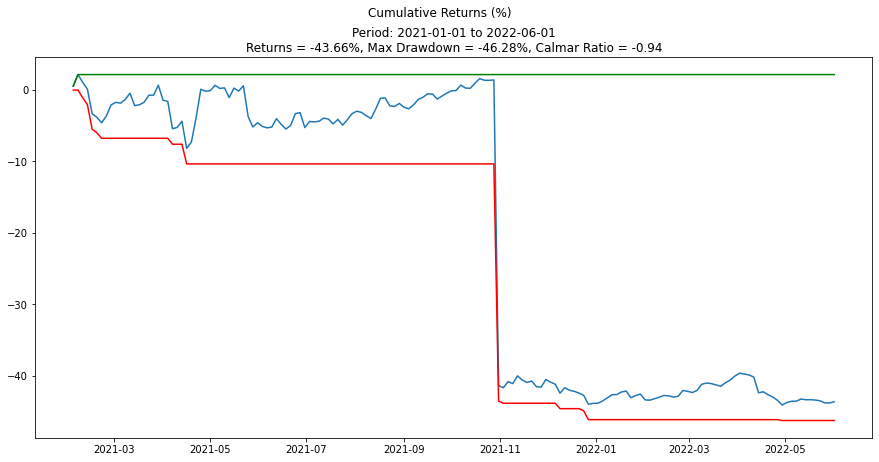

In [199]:
# rolling backest
params = {
    'start_date': datetime.fromisoformat('2021-01-01 00:00:00+00:00'),
    'end_date': datetime.fromisoformat('2022-06-01 00:00:00+00:00'),
    'minimum_dollars_per_unit': 1,
    'maximum_dollars_per_unit': 1000,
    'formation_period_days': 30,
    'trading_period_days': 3,
    'taker_fee': 0.0007,
    'entry_multiple': 1.5,
    'stop_multiple': 3,
    'half_life_multiple': 1,
    'nbr_max_pairs': 10,
    'display_cluster': False
}

backtest_result = rolling_backtest_mean_reversion(prices_df, params, True)

<AxesSubplot:ylabel='Frequency'>

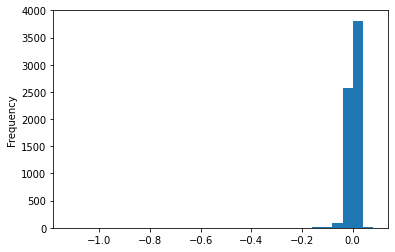

In [200]:
backtest_result['rolling_trades']['returns'].plot.hist(bins=30)

<AxesSubplot:ylabel='Frequency'>

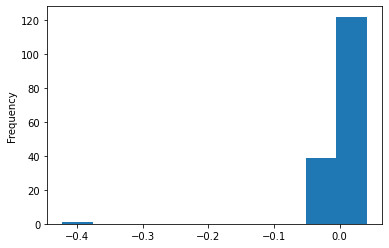

In [201]:
backtest_result['periods_breakdown']['returns'].plot.hist()

In [205]:
backtest_result['periods_breakdown'].sort_values(['returns'])

,period_start,period_end,returns
90,2021-09-28 00:00:00+00:00,2021-10-31 00:00:00+00:00,-0.422002
37,2021-04-22 00:00:00+00:00,2021-05-25 00:00:00+00:00,-0.042574
24,2021-03-14 00:00:00+00:00,2021-04-16 00:00:00+00:00,-0.039778
21,2021-03-05 00:00:00+00:00,2021-04-07 00:00:00+00:00,-0.038867
145,2022-03-12 00:00:00+00:00,2022-04-14 00:00:00+00:00,-0.036781
...,...,...,...
47,2021-05-22 00:00:00+00:00,2021-06-24 00:00:00+00:00,0.017527
100,2021-10-28 00:00:00+00:00,2021-11-30 00:00:00+00:00,0.018284
94,2021-10-10 00:00:00+00:00,2021-11-12 00:00:00+00:00,0.018387
26,2021-03-20 00:00:00+00:00,2021-04-22 00:00:00+00:00,0.036834


In [203]:
backtest_result['rolling_trades'].sort_values(['returns'])[:20]

,pair,date_open,date_close,position,price_a_open,price_b_open,price_a_close,price_b_close,spread_open,spread_close,beta,one_unit_dollar_size,pnl,fee,pnl_after_fee,returns,duration
31,THETA-PERP/MANA-PERP,2021-10-30 08:00:00+00:00,2021-10-31 00:00:00+00:00,-1,6.818500,1.4211,8.310750,3.68790,0.917326,3.073874,0.073883,1.924874,-2.156547,0.001347,-2.157895,-1.121058,0 days 16:00:00
27,EOS-PERP/MANA-PERP,2021-10-30 08:00:00+00:00,2021-10-31 00:00:00+00:00,-1,4.444000,1.4211,4.512250,3.68790,0.819407,3.076967,0.135394,2.022793,-2.257559,0.001416,-2.258975,-1.116761,0 days 16:00:00
36,ETC-PERP/MANA-PERP,2021-10-30 08:00:00+00:00,2021-10-31 00:00:00+00:00,-1,52.754500,1.4211,52.975000,3.68790,0.679152,2.942851,0.014064,2.163048,-2.263699,0.001514,-2.265213,-1.047232,0 days 16:00:00
29,SHIT-PERP/MANA-PERP,2021-10-30 08:00:00+00:00,2021-10-31 00:00:00+00:00,-1,7529.500000,1.4211,8882.000000,3.68790,0.777423,2.928601,0.000085,2.064777,-2.151178,0.001445,-2.152624,-1.042545,0 days 16:00:00
30,THETA-PERP/MANA-PERP,2021-10-28 22:00:00+00:00,2021-10-30 03:00:00+00:00,-1,6.403300,0.9113,6.805050,1.29270,0.438202,0.789920,0.073883,1.384398,-0.351717,0.000969,-0.352686,-0.254758,1 days 05:00:00
26,EOS-PERP/MANA-PERP,2021-10-28 21:00:00+00:00,2021-10-30 03:00:00+00:00,-1,4.411000,0.9201,4.457500,1.29270,0.322875,0.689179,0.135394,1.517325,-0.366304,0.001062,-0.367366,-0.242114,1 days 06:00:00
28,SHIT-PERP/MANA-PERP,2021-10-28 21:00:00+00:00,2021-10-30 03:00:00+00:00,-1,7167.100000,0.9201,7470.100000,1.29270,0.307403,0.654101,0.000085,1.532797,-0.346697,0.001073,-0.347770,-0.226886,1 days 06:00:00
35,ETC-PERP/MANA-PERP,2021-10-28 22:00:00+00:00,2021-10-30 03:00:00+00:00,-1,51.949500,0.9113,52.935000,1.29270,0.180674,0.548214,0.014064,1.641926,-0.367540,0.001149,-0.368689,-0.224547,1 days 05:00:00
7,ETC-PERP/FIL-PERP,2021-02-13 04:00:00+00:00,2021-02-14 05:00:00+00:00,1,12.412000,44.9750,16.139500,41.89500,-17.982208,-39.969153,5.072286,107.932208,-21.986944,0.075553,-22.062497,-0.204411,1 days 01:00:00
3,ETC-PERP/BNB-PERP,2021-02-13 16:00:00+00:00,2021-02-14 05:00:00+00:00,1,12.845000,131.1825,16.139500,129.27750,-177.390504,-258.438654,24.022811,439.755504,-81.048150,0.307829,-81.355979,-0.185003,0 days 13:00:00
